# Imports and Configurações

In [1]:
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plot
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

# Funções de Custo

###### Para Regressão

In [4]:
def mae(y, y_pred,derivative=False):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    return np.mean(np.abs(y - y_pred))

def mse(y, y_pred,derivative=False):
    if derivative:
        return -(y - y_pred) / y.shape[0]
    return 0.5 * np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [5]:
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])
    
    return -np.mean(y*np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sigmoid(y_pred)
    
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    return -np.mean(y*np.log(y_sigmoid) + (1 - y)*np.log(1 - y_sigmoid))

###### Para Classificação Multiclasse

In [6]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]    
    return neg_log_likelihood(y_oh, y_softmax)

# Inicialização de Pesos

In [7]:
def zeros(rows, cols):
    return np.zeros((rows, cols))

def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    std_dev = np.sqrt(2.0 / (rows + cols))
    return std_dev * np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    limit = np.sqrt(6.0 / (rows + cols))
    return limit * np.random.randn(rows, cols) - limit


# Regularização

In [8]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return np.array([np.where(w > 0, 1, w) for w in weights])
    return np.sum([np.sum(np.abs*(w)) for w in weights])

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights**2)

# Batch Generator

In [9]:
def batch_sequential(x, y, batch_size=None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batches = x.shape[0] // batch_size
    
    for batch in range(n_batches):
        offset = batch_size * batch
        x_batch, y_batch = x[offset:offset+batch_size], y[offset:offset+batch_size]
        yield (x_batch, y_batch)
        
def batch_shuffle(x, y, batch_size=None):
    shuffle_index = np.random.permutation(range(x.shape[0]))
    return batch_sequential(x[shuffle_index], y[shuffle_index], batch_size)

# Learning Rate Decay

In [10]:
def none_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate

def time_based_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return 1.0 / (1 + decay_rate  * epoch)

def exponential_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate ** epoch

def staircase_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate ** (epoch // decay_steps)

# Batch Normalization 

In [11]:
def batchnorm_foward(layer, x, is_training=True):
    mu = np.mean(x, axis=0) if is_training else layer._pop_mean
    var = np.var(x, axis=0) if is_training else layer._pop_var
    x_norm = (x - mu) / np.sqrt(var + 1e-8)
    out = layer.gamma * x_norm + layer.beta
    
    if is_training:
        layer._pop_mean = layer.bn_decay * layer._pop_mean + (1.0 - layer.bn_decay) * mu
        layer._pop_var = layer.bn_decay * layer._pop_var + (1.0 - layer.bn_decay) * var
        layer._bn_cache = (x, x_norm, mu, var)
    return out
        
def batchnorm_backward(layer, dactivation):
    x, x_norm, mu, var = layer._bn_cache
    
    m = layer._activ_inp.shape[0]
    x_mu = x - mu
    std_inv = 1.0 / np.sqrt(var + 1e-8)
    
    dx_norm = dactivation * layer.gamma
    dvar = np.sum(dx_norm* x_mu, axis=0) * -0.5 * (std_inv**3)
    dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2.0 * x_mu, axis=0)
    
    dx = (dx_norm * std_inv) + (dvar * 2.0 * x_mu / m) + (dmu/m)
    layer._dgamma = np.sum(dactivation * x_norm, axis=0)
    layer._dbeta = np.sum(dactivation, axis=0)
    
    return dx

# Implementação 

In [12]:
class Layer():
    def __init__(self, input_dim, output_dim, weights_initializer=random_normal, biases_initializer=ones,activation=linear, droput_prob=0, reg_func=l2_regularization, reg_strength=0.0, batch_norm=False, bn_decay=0.9, is_trainable=True):
        self.input_dim = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self.droput_prob = droput_prob
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        self.batch_norm = batch_norm
        self.bn_decay = bn_decay
        self.is_trainable = is_trainable
        self.gamma, self.beta = ones(1, output_dim), zeros(1, output_dim)

        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        self._dropout_mask = None
        self._dgamma, self._dbeta = None,None
        self._pop_mean, self._pop_var = zeros(1, output_dim), zeros(1, output_dim)
        self._bn_cache = None
    
class NeuronNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3,lr_decay_method=none_decay, lr_decay_rate=0.0, lr_decay_steps=1,momentum=0.0, patience=np.inf):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = self.lr_initial = learning_rate
        self.lr_decay_method = lr_decay_method
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_steps = lr_decay_steps
        self.momentum = momentum
        self.patience, self.waiting = patience, 0
        self._best_model, self._best_loss = self.layers, np.inf
        
    def fit(self, x_train, y_train, x_val=None, y_val=None, epochs=100, verbose=10, batch_gen=batch_sequential, batch_size=None, batch_norm=False, bn_decay=0.9):
        x_val, y_val = (x_train, y_train) if (x_val is None or y_val is None) else (x_val, y_val)
        
        for epoch in range(epochs+1):
            self.learning_rate = self.lr_decay_method(self.lr_initial, epoch, self.lr_decay_rate, self.lr_decay_steps)
            
            for x_batch, y_batch in batch_gen(x_train, y_train, batch_size):
                y_pred = self.__feedfoward(x_batch)
                self.__backprop(y_batch, y_pred)
            
            loss_val = self.cost_func(y_val, self.predict(x_val))
            
            if loss_val < self._best_loss:
                self._best_model, self._best_loss = self.layers, loss_val
                self.waiting = 0
            else:
                self.waiting += 1
                if self.waiting >= self.patience:
                    self.layers = self._best_model
                    return
            
            if epoch % verbose == 0:
                loss_train = self.cost_func(y_train, self.predict(x_train))
                loss_reg = (1.0 / y_train.shape[0]) * np.sum([layer.reg_func(layer.weights) * layer.reg_strength for layer in self.layers])
                print("Epoch {0:=4}/{1} loss_train: {2:.8f} + {3:.8f} = {4:.8f} loss_val = {5:.8f}".format(epoch, epochs,loss_train, loss_reg,loss_train+loss_reg, loss_val))
    
    def predict(self, x):
        return self.__feedfoward(x, is_training=False)
    
    def save(self, file_path):
        pkl.dump(self, open(file_path, 'wb'), -1)
        
    def load(file_path):
        return pkl.load(open(file_path, 'rb'))
    
    def __feedfoward(self, x, is_training=True):
        self.layers[0].input = x
        for current_layer , next_layer in zip(self.layers, self.layers[1:] + [Layer(0,0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            y = batchnorm_foward(current_layer, y, is_training) if current_layer.batch_norm else y
            current_layer.droput_mask = np.random.binomial(1, 1.0 - current_layer.droput_prob, y.shape) / (1.0 - current_layer.droput_prob)
            current_layer._activ_inp = y
            current_layer._activ_out = current_layer.activation(y) * (current_layer.droput_mask if is_training else 1.0)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out
    
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            deactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta * layer.droput_mask
            deactivation = batchnorm_backward(layer, deactivation) if layer.batch_norm else deactivation
            last_delta = np.dot(deactivation, layer.weights)
            layer._dweights = np.dot(deactivation.T, layer.input)
            layer._dbiases = 1.0 * deactivation.sum(axis=0, keepdims=True)
            
        for layer in reversed(self.layers):
            if layer.is_trainable:
                layer._dweights = layer._dweights + (1.0 / y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights, derivative=True)
                layer._prev_dweights = - self.learning_rate * layer._dweights + self.momentum*layer._prev_dweights
                layer.weights = layer.weights - self.learning_rate * layer._dweights
                layer.biases = layer.biases - self.learning_rate * layer._dbiases

                if layer.batch_norm:
                    layer.gamma = layer.gamma - self.learning_rate * layer._dgamma
                    layer.beta = layer.beta - self.learning_rate * layer._dbeta

In [13]:
#Testing early stopping
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

x, y = make_regression(n_samples=100, n_features=1, n_informative=2, noise=10.0, random_state=42)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)

print(x.shape, y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

nn = NeuronNetwork(cost_func=mse, learning_rate=1e-1, patience=10)
nn.layers.append(Layer(input_dim=x.shape[1], output_dim=y.shape[1], activation=linear))

nn.fit(x_train, y_train, x_val=x_test, y_val=y_test, epochs=1000, verbose=50)

(100, 1) (100, 1)
Epoch    0/1000 loss_train: 708.47271170 + 0.00000000 = 708.47271170 loss_val = 745.63418316
Epoch   50/1000 loss_train: 35.45138309 + 0.00000000 = 35.45138309 loss_val = 53.35941189
Epoch  100/1000 loss_train: 35.23224826 + 0.00000000 = 35.23224826 loss_val = 51.77174912
Epoch  150/1000 loss_train: 35.23214680 + 0.00000000 = 35.23214680 loss_val = 51.73729192
Epoch  200/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73653032
Epoch  250/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651378
Epoch  300/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651343
Epoch  350/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651342
Epoch  400/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651342
Epoch  450/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651342


## Gradient Checking

In [15]:
def __compute_approx_grads(nn, x, y, eps=1e-4):
    approx_grads = []
    feed_foward = lambda inp: nn._NeuronNetwork__feedfoward(inp, is_training=True)
    
    for layer in nn.layers:
        w_ori = layer.weights.copy()
        w_ravel = w_ori.ravel()
        w_shape = w_ori.shape
        
        for i in range(w_ravel.size):
            w_plus = w_ravel.copy()
            w_plus[i] += eps
            layer.weights = w_plus.reshape(w_shape)
            J_plus = nn.cost_func(y, feed_foward(x))
            
            w_minus = w_ravel.copy()
            w_minus[i] -= eps
            layer.weights = w_minus.reshape(w_shape)
            J_minus = nn.cost_func(y, feed_foward(x))
            approx_grads.append((J_plus-J_minus) / (2.0 * eps))
        layer.weights = w_ori
    
    return approx_grads
            

def gradient_cheking(nn, x, y, eps=1e-4, verbose=False, verbose_precision=5):
    from copy import deepcopy
    nn_copy = deepcopy(nn)
    
    nn.fit(x, y, epochs=0)
    grads = np.concatenate([layer._dweights.ravel() for layer in nn.layers])
    approx_grads = __compute_approx_grads(nn_copy, x, y, eps)
    
    is_close = np.allclose(grads, approx_grads)
    print("{}".format("\033[92mGRADIENTS OK" if is_close else "\033[91mGRADIENTS FAIL"))
    
    norm_num = np.linalg.norm(grads - approx_grads)
    norm_den =  np.linalg.norm(grads) +  np.linalg.norm(approx_grads)
    error = norm_num / norm_den
    print("Relative error: ", error)
    
    if verbose:
        np.set_printoptions(precision=verbose_precision, linewidth=200, suppress=True)
        print("Gradientes: ", grads)
        print("Aproximado: ", np.array(approx_grads))

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

(100, 2)
(100, 1) (100, 1)


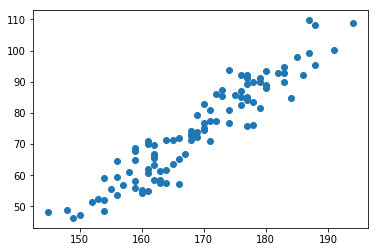

In [16]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)
plt.scatter(x, y)

-1.0 0.9999999999999991


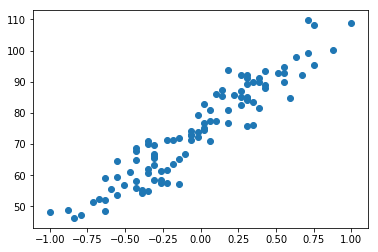

In [17]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())
plt.scatter(x, y)

Epoch    0/1000 loss_train: 2291.22725683 + 0.00000000 = 2291.22725683 loss_val = 2291.22725683
Epoch  100/1000 loss_train: 17.84080851 + 0.00000000 = 17.84080851 loss_val = 17.84080851
Epoch  200/1000 loss_train: 14.21479471 + 0.00000000 = 14.21479471 loss_val = 14.21479471
Epoch  300/1000 loss_train: 13.67932715 + 0.00000000 = 13.67932715 loss_val = 13.67932715
Epoch  400/1000 loss_train: 13.54164001 + 0.00000000 = 13.54164001 loss_val = 13.54164001
Epoch  500/1000 loss_train: 13.48992312 + 0.00000000 = 13.48992312 loss_val = 13.48992312
Epoch  600/1000 loss_train: 13.46919535 + 0.00000000 = 13.46919535 loss_val = 13.46919535
Epoch  700/1000 loss_train: 13.46118828 + 0.00000000 = 13.46118828 loss_val = 13.46118828
Epoch  800/1000 loss_train: 13.45764216 + 0.00000000 = 13.45764216 loss_val = 13.45764216
Epoch  900/1000 loss_train: 13.45611371 + 0.00000000 = 13.45611371 loss_val = 13.45611371
Epoch 1000/1000 loss_train: 13.45550488 + 0.00000000 = 13.45550488 loss_val = 13.45550488
[[31

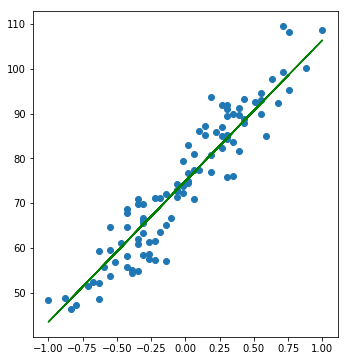

In [18]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuronNetwork(cost_func=mse, learning_rate=1e-1, lr_decay_method=staircase_decay, lr_decay_rate=0.6, lr_decay_steps=60)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))
nn.fit(x,y,epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [19]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [20]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [1. 1. 1.]


In [21]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuronNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))
nn.fit(x,y,epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

Epoch    0/2000 loss_train: 10014.08942540 + 0.00000000 = 10014.08942540 loss_val = 10014.08942540
Epoch  200/2000 loss_train: 6.92791107 + 0.00000000 = 6.92791107 loss_val = 6.92791107
Epoch  400/2000 loss_train: 4.04508289 + 0.00000000 = 4.04508289 loss_val = 4.04508289
Epoch  600/2000 loss_train: 3.24918634 + 0.00000000 = 3.24918634 loss_val = 3.24918634
Epoch  800/2000 loss_train: 3.00548895 + 0.00000000 = 3.00548895 loss_val = 3.00548895
Epoch 1000/2000 loss_train: 2.92218137 + 0.00000000 = 2.92218137 loss_val = 2.92218137
Epoch 1200/2000 loss_train: 2.89086199 + 0.00000000 = 2.89086199 loss_val = 2.89086199
Epoch 1400/2000 loss_train: 2.87825561 + 0.00000000 = 2.87825561 loss_val = 2.87825561
Epoch 1600/2000 loss_train: 2.87295991 + 0.00000000 = 2.87295991 loss_val = 2.87295991
Epoch 1800/2000 loss_train: 2.87068020 + 0.00000000 = 2.87068020 loss_val = 2.87068020
Epoch 2000/2000 loss_train: 2.86968569 + 0.00000000 = 2.86968569 loss_val = 2.86968569
[[ 8.94355322 13.97312155 26.17

### Regressão Quadrática

(100, 1) (100, 1)


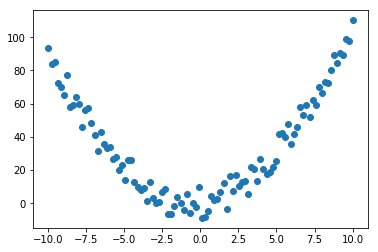

In [22]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [23]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch    0/5000 loss_train: 1123.02861983 + 0.00000000 = 1123.02861983 loss_val = 1123.02861983
Epoch  500/5000 loss_train: 29.87668399 + 0.00000000 = 29.87668399 loss_val = 29.87668399
Epoch 1000/5000 loss_train: 21.36464506 + 0.00000000 = 21.36464506 loss_val = 21.36464506
Epoch 1500/5000 loss_train: 20.67149735 + 0.00000000 = 20.67149735 loss_val = 20.67149735
Epoch 2000/5000 loss_train: 19.36111025 + 0.00000000 = 19.36111025 loss_val = 19.36111025
Epoch 2500/5000 loss_train: 18.88607107 + 0.00000000 = 18.88607107 loss_val = 18.88607107
Epoch 3000/5000 loss_train: 19.02527218 + 0.00000000 = 19.02527218 loss_val = 19.02527218
Epoch 3500/5000 loss_train: 18.10086620 + 0.00000000 = 18.10086620 loss_val = 18.10086620
Epoch 4000/5000 loss_train: 17.78204716 + 0.00000000 = 17.78204716 loss_val = 17.78204716
Epoch 4500/5000 loss_train: 26.41137296 + 0.00000000 = 26.41137296 loss_val = 26.41137296
Epoch 5000/5000 loss_train: 18.18966528 + 0.00000000 = 18.18966528 loss_val = 18.18966528
[[ 0

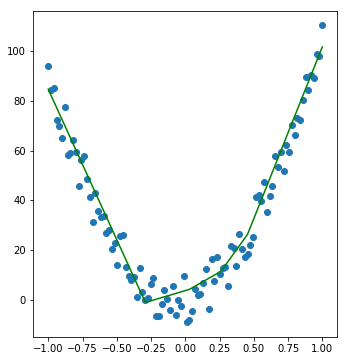

In [27]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuronNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear))
nn.fit(x,y,epochs=5000, verbose=500)

print(nn.layers[0].weights)
print(nn.layers[0].biases)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

(100, 1) (100, 1)


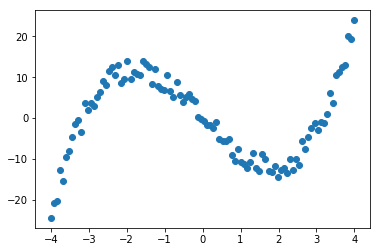

In [28]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [29]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch    0/5000 loss_train: 130.53703540 + 0.00000000 = 130.53703540 loss_val = 130.53703540
Epoch  500/5000 loss_train: 16.29825060 + 0.00000000 = 16.29825060 loss_val = 16.29825060
Epoch 1000/5000 loss_train: 9.72700572 + 0.00000000 = 9.72700572 loss_val = 9.72700572
Epoch 1500/5000 loss_train: 6.95014138 + 0.00000000 = 6.95014138 loss_val = 6.95014138
Epoch 2000/5000 loss_train: 4.99285827 + 0.00000000 = 4.99285827 loss_val = 4.99285827
Epoch 2500/5000 loss_train: 4.52116531 + 0.00000000 = 4.52116531 loss_val = 4.52116531
Epoch 3000/5000 loss_train: 4.20762740 + 0.00000000 = 4.20762740 loss_val = 4.20762740
Epoch 3500/5000 loss_train: 3.87596982 + 0.00000000 = 3.87596982 loss_val = 3.87596982
Epoch 4000/5000 loss_train: 3.40238013 + 0.00000000 = 3.40238013 loss_val = 3.40238013
Epoch 4500/5000 loss_train: 3.55734554 + 0.00000000 = 3.55734554 loss_val = 3.55734554
Epoch 5000/5000 loss_train: 3.51274644 + 0.00000000 = 3.51274644 loss_val = 3.51274644


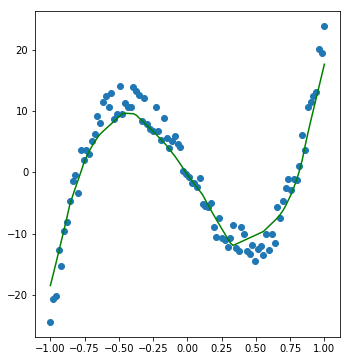

In [30]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuronNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=50, activation=relu, droput_prob=0.5))
nn.layers.append(Layer(input_dim=50, output_dim=output_dim, activation=linear))
nn.fit(x,y,epochs=5000, verbose=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

(100, 1) (100, 1)


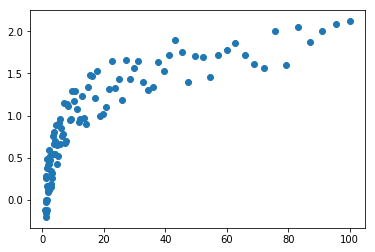

In [31]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [32]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch    0/5000 loss_train: 1.32944121 + 0.00000000 = 1.32944121 loss_val = 1.32944121
Epoch  500/5000 loss_train: 0.02369883 + 0.00000000 = 0.02369883 loss_val = 0.02369883
Epoch 1000/5000 loss_train: 0.02159761 + 0.00000000 = 0.02159761 loss_val = 0.02159761
Epoch 1500/5000 loss_train: 0.02048712 + 0.00000000 = 0.02048712 loss_val = 0.02048712
Epoch 2000/5000 loss_train: 0.01976579 + 0.00000000 = 0.01976579 loss_val = 0.01976579
Epoch 2500/5000 loss_train: 0.01924936 + 0.00000000 = 0.01924936 loss_val = 0.01924936
Epoch 3000/5000 loss_train: 0.01885296 + 0.00000000 = 0.01885296 loss_val = 0.01885296
Epoch 3500/5000 loss_train: 0.01853493 + 0.00000000 = 0.01853493 loss_val = 0.01853493
Epoch 4000/5000 loss_train: 0.01827593 + 0.00000000 = 0.01827593 loss_val = 0.01827593
Epoch 4500/5000 loss_train: 0.01805805 + 0.00000000 = 0.01805805 loss_val = 0.01805805
Epoch 5000/5000 loss_train: 0.01787116 + 0.00000000 = 0.01787116 loss_val = 0.01787116


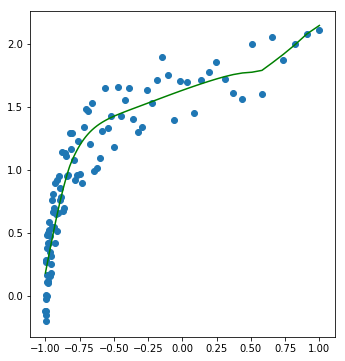

In [37]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuronNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear))
nn.fit(x,y,epochs=5000, verbose=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

(100, 1) (100, 1)


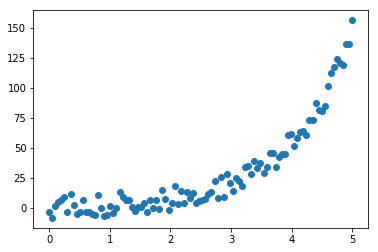

In [38]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [39]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch    0/5000 loss_train: 1391.25835516 + 0.00000000 = 1391.25835516 loss_val = 1391.25835516
Epoch  500/5000 loss_train: 20.50777906 + 0.00000000 = 20.50777906 loss_val = 20.50777906
Epoch 1000/5000 loss_train: 17.80555327 + 0.00000000 = 17.80555327 loss_val = 17.80555327
Epoch 1500/5000 loss_train: 17.46029660 + 0.00000000 = 17.46029660 loss_val = 17.46029660
Epoch 2000/5000 loss_train: 17.40085331 + 0.00000000 = 17.40085331 loss_val = 17.40085331
Epoch 2500/5000 loss_train: 17.37686452 + 0.00000000 = 17.37686452 loss_val = 17.37686452
Epoch 3000/5000 loss_train: 17.35995103 + 0.00000000 = 17.35995103 loss_val = 17.35995103
Epoch 3500/5000 loss_train: 17.34525243 + 0.00000000 = 17.34525243 loss_val = 17.34525243
Epoch 4000/5000 loss_train: 17.33218259 + 0.00000000 = 17.33218259 loss_val = 17.33218259
Epoch 4500/5000 loss_train: 17.32045765 + 0.00000000 = 17.32045765 loss_val = 17.32045765
Epoch 5000/5000 loss_train: 17.30993555 + 0.00000000 = 17.30993555 loss_val = 17.30993555


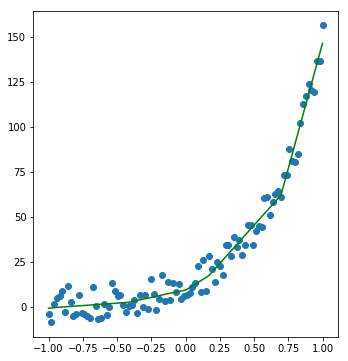

In [40]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuronNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear))
nn.fit(x,y,epochs=5000, verbose=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

(4, 2) (4, 1)


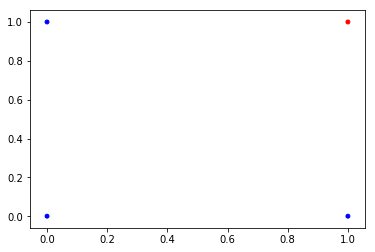

In [41]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch    0/1000 loss_train: 0.96876751 + 0.00000000 = 0.96876751 loss_val = 0.96876751
Epoch  100/1000 loss_train: 0.13920631 + 0.00000000 = 0.13920631 loss_val = 0.13920631
Epoch  200/1000 loss_train: 0.08010992 + 0.00000000 = 0.08010992 loss_val = 0.08010992
Epoch  300/1000 loss_train: 0.05576344 + 0.00000000 = 0.05576344 loss_val = 0.05576344
Epoch  400/1000 loss_train: 0.04258952 + 0.00000000 = 0.04258952 loss_val = 0.04258952
Epoch  500/1000 loss_train: 0.03437573 + 0.00000000 = 0.03437573 loss_val = 0.03437573
Epoch  600/1000 loss_train: 0.02878158 + 0.00000000 = 0.02878158 loss_val = 0.02878158
Epoch  700/1000 loss_train: 0.02473376 + 0.00000000 = 0.02473376 loss_val = 0.02473376
Epoch  800/1000 loss_train: 0.02167273 + 0.00000000 = 0.02167273 loss_val = 0.02167273
Epoch  900/1000 loss_train: 0.01927885 + 0.00000000 = 0.01927885 loss_val = 0.01927885
Epoch 1000/1000 loss_train: 0.01735660 + 0.00000000 = 0.01735660 loss_val = 0.01735660
Predições:
[[-11.30415453]
 [ -3.88311271]


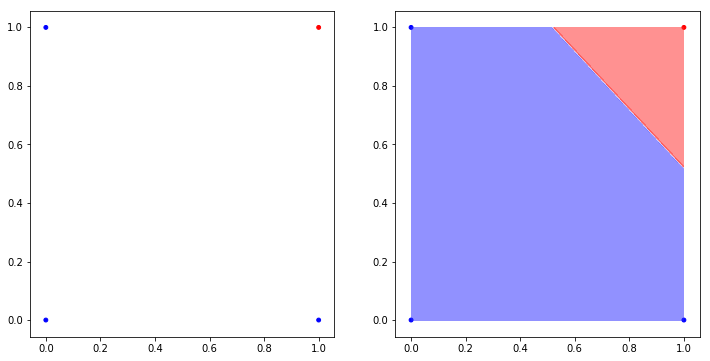

In [42]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuronNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))
nn.fit(x,y,epochs=1000, verbose=100)


y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, cmap='bwr')

### 2 Clusters

(100, 2) (100, 1)


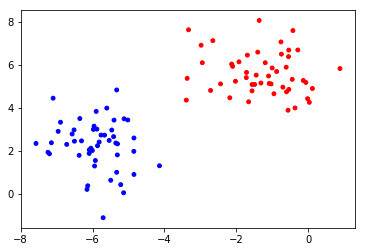

In [45]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch    0/5000 loss_train: 1.56284197 + 0.00000000 = 1.56284197 loss_val = 1.56284197
Epoch 1000/5000 loss_train: 0.00607187 + 0.00000000 = 0.00607187 loss_val = 0.00607187
Epoch 2000/5000 loss_train: 0.00414355 + 0.00000000 = 0.00414355 loss_val = 0.00414355
Epoch 3000/5000 loss_train: 0.00330277 + 0.00000000 = 0.00330277 loss_val = 0.00330277
Epoch 4000/5000 loss_train: 0.00280347 + 0.00000000 = 0.00280347 loss_val = 0.00280347
Epoch 5000/5000 loss_train: 0.00246267 + 0.00000000 = 0.00246267 loss_val = 0.00246267
Acurácia: 100.00%


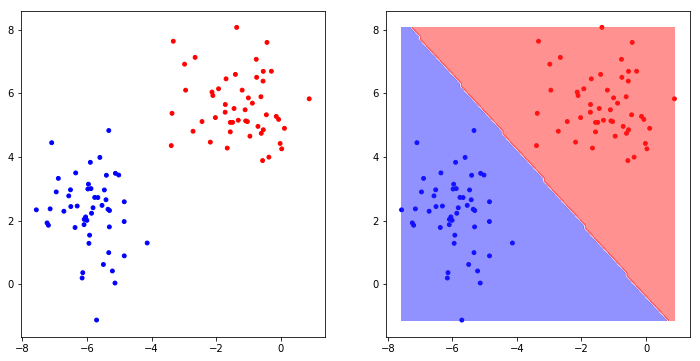

In [46]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuronNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=sigmoid))
nn.fit(x,y,epochs=5000, verbose=1000)


y_pred = nn.predict(x)

threshold = 0 if nn.layers[-1].activation == linear else 0.5
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= threshold)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

(500, 2) (500, 1)


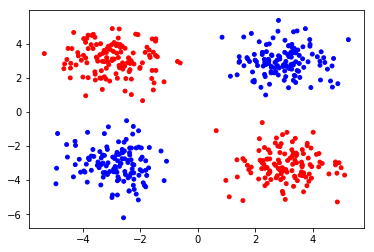

In [47]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch    0/1000 loss_train: 1.67658752 + 0.00000000 = 1.67658752 loss_val = 1.67658752
Epoch  100/1000 loss_train: 0.04869308 + 0.00000000 = 0.04869308 loss_val = 0.04869308
Epoch  200/1000 loss_train: 0.02675530 + 0.00000000 = 0.02675530 loss_val = 0.02675530
Epoch  300/1000 loss_train: 0.01543522 + 0.00000000 = 0.01543522 loss_val = 0.01543522
Epoch  400/1000 loss_train: 0.01097489 + 0.00000000 = 0.01097489 loss_val = 0.01097489
Epoch  500/1000 loss_train: 0.00876513 + 0.00000000 = 0.00876513 loss_val = 0.00876513
Epoch  600/1000 loss_train: 0.00606859 + 0.00000000 = 0.00606859 loss_val = 0.00606859
Epoch  700/1000 loss_train: 0.00394910 + 0.00000000 = 0.00394910 loss_val = 0.00394910
Epoch  800/1000 loss_train: 0.00290483 + 0.00000000 = 0.00290483 loss_val = 0.00290483
Epoch  900/1000 loss_train: 0.00224877 + 0.00000000 = 0.00224877 loss_val = 0.00224877
Epoch 1000/1000 loss_train: 0.00182439 + 0.00000000 = 0.00182439 loss_val = 0.00182439
Acurácia: 100.00%


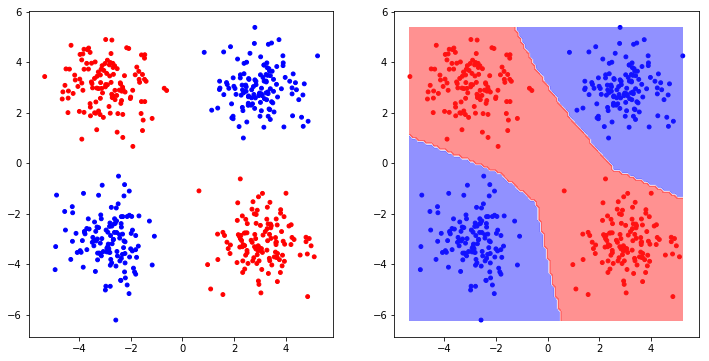

In [48]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuronNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=output_dim, activation=sigmoid))
nn.fit(x,y,epochs=1000, verbose=100)


y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

(500, 2) (500, 1)


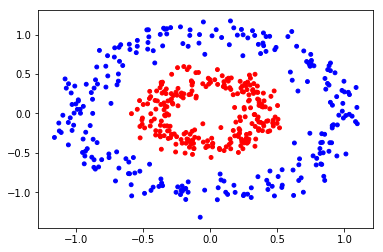

In [49]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch    0/1000 loss_train: 1.10499040 + 0.00000000 = 1.10499040 loss_val = 1.10499040
Epoch 1000/1000 loss_train: 0.01042118 + 0.00000000 = 0.01042118 loss_val = 0.01042118
Acurácia: 100.00%


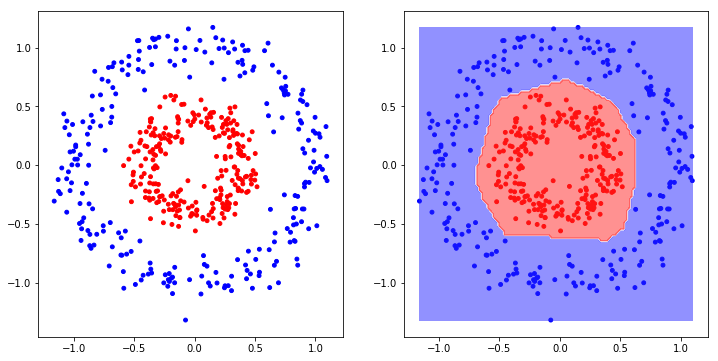

In [50]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuronNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=output_dim, activation=sigmoid))
nn.fit(x,y,epochs=1000, verbose=1000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

(200, 2) (200, 1)


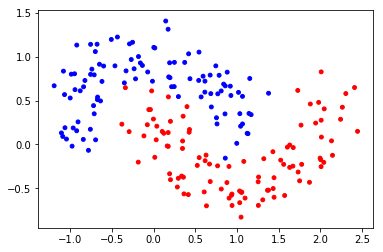

In [51]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch    0/1000 loss_train: 1.27556408 + 0.03987779 = 1.31544187 loss_val = 1.27556408
Epoch 1000/1000 loss_train: 0.28680275 + 0.03981455 = 0.32661730 loss_val = 0.28680275
Acurácia: 86.50%


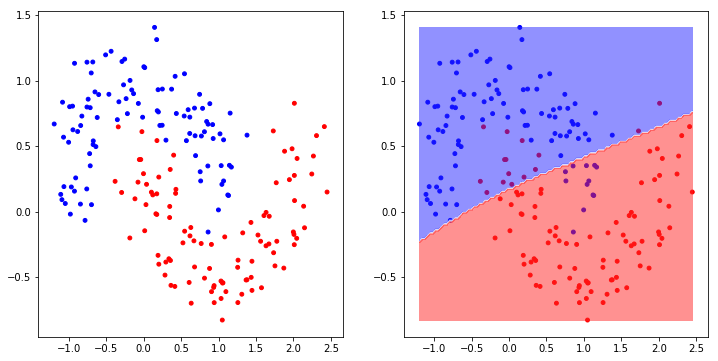

In [52]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuronNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=8, activation=tanh, reg_strength=1.0,reg_func=l2_regularization))
nn.layers.append(Layer(input_dim=8, output_dim=output_dim, activation=sigmoid, reg_strength=1.0, reg_func=l2_regularization))
nn.fit(x,y,epochs=1000, verbose=1000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')